# Car Evaluation

Among the basic classification techniques that you are familiar with (i.e., decision tree, k-NN, logistic regression, NB, SVM) use all that would be applicable to this dataset to predict the evaluation of the cars based on their characteristics. Explore how well these techniques perform for several different parameter values.

## Set-up

In [1]:
%matplotlib inline
# import necessary libraries and specify that graphs should be plotted inline.

import pandas as pd
import numpy as np
import seaborn as sns # data visualization library  
import matplotlib.pyplot as plt

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
car_evaluation = fetch_ucirepo(id=19) 
  
# data (as pandas dataframes) 
X = car_evaluation.data.features 
y = car_evaluation.data.targets 
  
# metadata 
print(car_evaluation.metadata) 
  
# variable information 
print(car_evaluation.variables) 

{'uci_id': 19, 'name': 'Car Evaluation', 'repository_url': 'https://archive.ics.uci.edu/dataset/19/car+evaluation', 'data_url': 'https://archive.ics.uci.edu/static/public/19/data.csv', 'abstract': 'Derived from simple hierarchical decision model, this database may be useful for testing constructive induction and structure discovery methods.', 'area': 'Other', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1728, 'num_features': 6, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1988, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5JP48', 'creators': ['Marko Bohanec'], 'intro_paper': {'title': 'Knowledge acquisition and explanation for multi-attribute decision making', 'authors': 'M. Bohanec, V. Rajkovič', 'published_in': '8th Intl Workshop on Expert Systems and their Applications, Avignon, France', 'yea

## Exploratory Data Analysis

In [3]:
print(X.head(20))
print(y.head(20))
print(X.columns)

   buying  maint doors persons lug_boot safety
0   vhigh  vhigh     2       2    small    low
1   vhigh  vhigh     2       2    small    med
2   vhigh  vhigh     2       2    small   high
3   vhigh  vhigh     2       2      med    low
4   vhigh  vhigh     2       2      med    med
5   vhigh  vhigh     2       2      med   high
6   vhigh  vhigh     2       2      big    low
7   vhigh  vhigh     2       2      big    med
8   vhigh  vhigh     2       2      big   high
9   vhigh  vhigh     2       4    small    low
10  vhigh  vhigh     2       4    small    med
11  vhigh  vhigh     2       4    small   high
12  vhigh  vhigh     2       4      med    low
13  vhigh  vhigh     2       4      med    med
14  vhigh  vhigh     2       4      med   high
15  vhigh  vhigh     2       4      big    low
16  vhigh  vhigh     2       4      big    med
17  vhigh  vhigh     2       4      big   high
18  vhigh  vhigh     2    more    small    low
19  vhigh  vhigh     2    more    small    med
    class
0  

In [28]:
# Check if there is missing data
print(X.isnull().sum())
print(y.isnull().sum())

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
dtype: int64
class    0
dtype: int64


In [4]:
# Check the distribution of features 
for col in X.columns:
    print(X[col].value_counts())

vhigh    432
high     432
med      432
low      432
Name: buying, dtype: int64
vhigh    432
high     432
med      432
low      432
Name: maint, dtype: int64
2        432
3        432
4        432
5more    432
Name: doors, dtype: int64
2       576
4       576
more    576
Name: persons, dtype: int64
small    576
med      576
big      576
Name: lug_boot, dtype: int64
low     576
med     576
high    576
Name: safety, dtype: int64


unacc    1210
acc       384
good       69
vgood      65
Name: class, dtype: int64


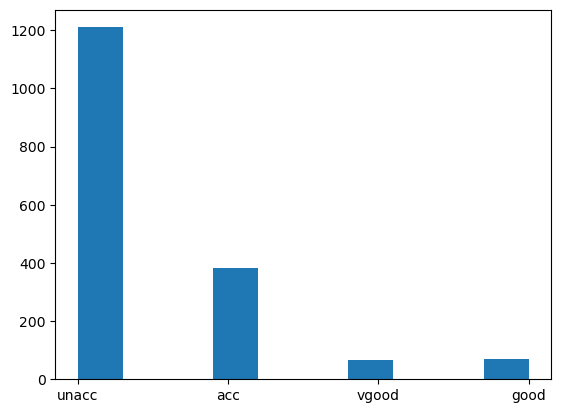

In [5]:
# Check the distribution of target variable 
print(y['class'].value_counts())
plt.hist(y)
plt.show()

## Data Pre-Processing

In [8]:
# import category encoders
import category_encoders as ce

In [9]:
encoder = ce.OrdinalEncoder(cols=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'])

X = encoder.fit_transform(X)

In [10]:
print(X.head())

   buying  maint  doors  persons  lug_boot  safety
0       1      1      1        1         1       1
1       1      1      1        1         1       2
2       1      1      1        1         1       3
3       1      1      1        1         2       1
4       1      1      1        1         2       2


# Part 1. Treat the data as Numerical

## Nested CV

In [15]:
from nested_cv import NestedCV
from sklearn.svm import SVC
from sklearn import neighbors
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score



# When using Random Search, we get a user warning with this little number of hyperparameters
# Suppress it
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

#### 1. K-nearest neighbors

In [94]:
# Number of random trials
NUM_TRIALS = 10

# Define a parameters grid
knn_grid = {"n_neighbors": list(range(1, 40))}

knn = neighbors.KNeighborsClassifier(algorithm='auto')

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=knn, param_grid=knn_grid, cv=inner_cv)
    clf.fit(X, y)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X, y=y, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

print("mean score of outer cv is {0:6f}"
      .format(nested_score.mean()))

print("standard deviation of outer cv is {0:6f}"
      .format(nested_score.std()))


mean score of outer cv is 0.940414
standard deviation of outer cv is 0.019113


#### 2. Decision Tree

In [101]:
# Number of random trials
NUM_TRIALS = 10

# Define a parameters grid
dt_grid = {'criterion':['gini','entropy'],
           'max_depth':[3,5,7,9,11,15,20,30,40,50,70,90]}

dt = DecisionTreeClassifier(random_state=42)

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=dt, param_grid=dt_grid, cv=inner_cv)
    clf.fit(X, y)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X, y=y, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

print("mean score of outer cv is {0:6f}"
      .format(nested_score.mean()))

print("standard deviation of outer cv is {0:6f}"
      .format(nested_score.std()))

mean score of outer cv is 0.969924
standard deviation of outer cv is 0.016797


#### 3. Logistic Regression

In [102]:
# Number of random trials
NUM_TRIALS = 10

# Define a parameters grid
lr_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 
          'solver': ['newton-cg', 'lbfgs', 'liblinear']}

lr = LogisticRegression(random_state=42)

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=lr, param_grid=lr_grid, cv=inner_cv)
    clf.fit(X, y)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X, y=y, cv=outer_cv)
    nested_scores[i] = nested_score.mean()


print("mean score of outer cv is {0:6f}"
      .format(nested_score.mean()))

print("standard deviation of outer cv is {0:6f}"
      .format(nested_score.std()))

mean score of outer cv is 0.829297
standard deviation of outer cv is 0.014936


#### 4. Support Vector Machine

In [100]:
# Number of random trials
NUM_TRIALS = 10

# Define a parameters grid
svm_grid = {'C':[0.1,1,10,100],
          'gamma':[1,0.1,0.01,0.001,0.0001]}

svm = SVC(kernel="rbf", random_state=42)

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svm, param_grid=svm_grid, cv=inner_cv)
    clf.fit(X, y)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X, y=y, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

# score_difference = non_nested_scores - nested_scores


print("mean score of outer cv is {0:6f}"
      .format(nested_score.mean()))

print("standard deviation of outer cv is {0:6f}"
      .format(nested_score.std()))

mean score of outer cv is 0.994216
standard deviation of outer cv is 0.003653


## Modeling

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import label_binarize
from sklearn import tree
from itertools import cycle
from sklearn import linear_model

In [26]:
# split the data into training and testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Standarize the attributes columns
sts = StandardScaler()
x_train = sts.fit_transform(x_train)
x_test = sts.fit_transform(x_test)

#### 1. K-nearest neighbors

First we take a look into overall performance of the model

In [66]:
# Set the parameters by cross-validation
tuned_parameters = [{'n_neighbors': (1,40, 1), 
                     'leaf_size': (20,40,1),
                    'weights': ('uniform', 'distance')}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf1 = GridSearchCV(neighbors.KNeighborsClassifier(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf1.fit(x_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf1.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf1.cv_results_['mean_test_score']
    stds = clf1.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf1.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf1.predict(x_test)
    print(classification_report(y_true, y_pred))
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'leaf_size': 1, 'n_neighbors': 40, 'weights': 'distance'}

Grid scores on development set:

0.742 (+/-0.109) for {'leaf_size': 20, 'n_neighbors': 1, 'weights': 'uniform'}
0.742 (+/-0.109) for {'leaf_size': 20, 'n_neighbors': 1, 'weights': 'distance'}
0.715 (+/-0.309) for {'leaf_size': 20, 'n_neighbors': 40, 'weights': 'uniform'}
0.853 (+/-0.126) for {'leaf_size': 20, 'n_neighbors': 40, 'weights': 'distance'}
0.742 (+/-0.109) for {'leaf_size': 20, 'n_neighbors': 1, 'weights': 'uniform'}
0.742 (+/-0.109) for {'leaf_size': 20, 'n_neighbors': 1, 'weights': 'distance'}
0.774 (+/-0.132) for {'leaf_size': 40, 'n_neighbors': 1, 'weights': 'uniform'}
0.774 (+/-0.132) for {'leaf_size': 40, 'n_neighbors': 1, 'weights': 'distance'}
0.715 (+/-0.325) for {'leaf_size': 40, 'n_neighbors': 40, 'weights': 'uniform'}
0.853 (+/-0.098) for {'leaf_size': 40, 'n_neighbors': 40, 'weights': 'distance'}
0.774 (+/-0.132) for

##### Plot ROC curve and Calculate AUC score 

And then we want to know the per-class performance of the model

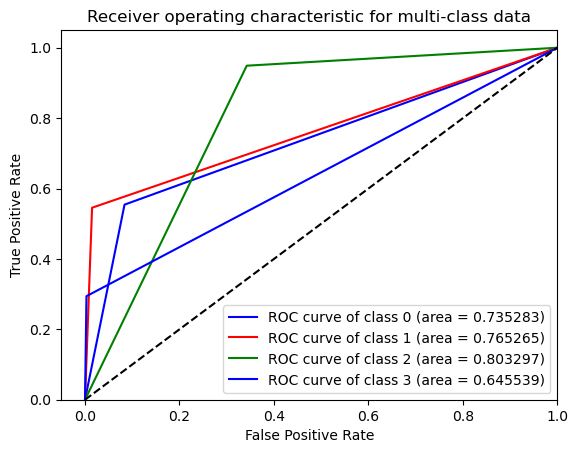

In [85]:
# Binarize the output
y_per = label_binarize(y, classes=['acc', 'good', 'unacc', 'vgood'])
n_classes = y_per.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y_per, test_size=.2, random_state=42)

# Apply the best parameters set found from grind search
classifier = OneVsRestClassifier(neighbors.KNeighborsClassifier(leaf_size=40, n_neighbors=1, weights='uniform'))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.6f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

#### 2. Decision Tree

In [83]:
# Split the dataset in two equal parts
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set the parameters by cross-validation
tuned_parameters = [{'max_depth' : (1, 30, 1),
                    'min_samples_split' : (2, 80, 3),
                    'criterion' :['gini', 'entropy']
                    }]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf2 = GridSearchCV(tree.DecisionTreeClassifier(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf2.fit(x_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf2.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf2.cv_results_['mean_test_score']
    stds = clf2.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf2.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf2.predict(x_test)
    print(classification_report(y_true, y_pred))
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'criterion': 'entropy', 'max_depth': 30, 'min_samples_split': 2}

Grid scores on development set:

0.176 (+/-0.001) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 2}
0.176 (+/-0.001) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 80}
0.176 (+/-0.001) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 3}
0.942 (+/-0.063) for {'criterion': 'gini', 'max_depth': 30, 'min_samples_split': 2}
0.533 (+/-0.041) for {'criterion': 'gini', 'max_depth': 30, 'min_samples_split': 80}
0.928 (+/-0.075) for {'criterion': 'gini', 'max_depth': 30, 'min_samples_split': 3}
0.176 (+/-0.001) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 2}
0.176 (+/-0.001) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 80}
0.176 (+/-0.001) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 3}
0.176 (+/-0.001) for {'criterion': 'entropy', 'max_depth': 

##### Plot ROC curve and Calculate AUC score

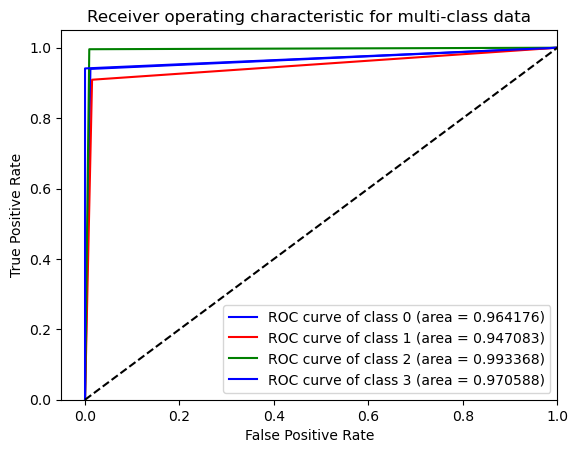

In [84]:
# Binarize the output
y_per = label_binarize(y, classes=['acc', 'good', 'unacc', 'vgood'])
n_classes = y_per.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y_per, test_size=.2, random_state=42)

# Apply the best parameters set found from grind search
classifier = OneVsRestClassifier(DecisionTreeClassifier(criterion='entropy', max_depth=30
                                                        , min_samples_split=2, random_state=42))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.6f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

#### 3. Logistic regression

In [75]:
# Split the dataset in two equal parts
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set the parameters by cross-validation
tuned_parameters = [{'penalty': ['l2'],
                     'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
                     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf3 = GridSearchCV(linear_model.LogisticRegression(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf3.fit(x_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf3.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf3.cv_results_['mean_test_score']
    stds = clf3.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf3.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf3.predict(x_test)
    print(classification_report(y_true, y_pred))
    print()


# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 1000, 'penalty': 'l2', 'solver': 'newton-cg'}

Grid scores on development set:

0.176 (+/-0.001) for {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
0.176 (+/-0.001) for {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
0.176 (+/-0.001) for {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
0.176 (+/-0.001) for {'C': 0.001, 'penalty': 'l2', 'solver': 'sag'}
0.176 (+/-0.001) for {'C': 0.001, 'penalty': 'l2', 'solver': 'saga'}
0.320 (+/-0.033) for {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
0.320 (+/-0.033) for {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
0.194 (+/-0.046) for {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
0.320 (+/-0.033) for {'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}
0.320 (+/-0.033) for {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}
0.678 (+/-0.245) for {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.678 (+/-0.245) for {'C': 0.1, 'penalty': 'l2', 

##### Plot ROC curve and Calculate AUC score

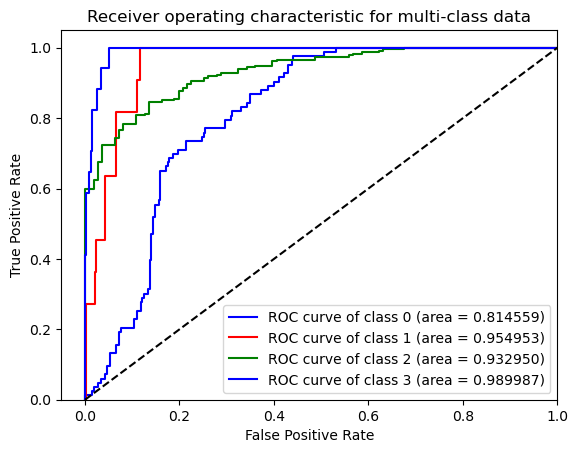

In [86]:
# Binarize the output
y_per = label_binarize(y, classes=['acc', 'good', 'unacc', 'vgood'])
n_classes = y_per.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y_per, test_size=.2, random_state=42)

# Apply the best parameters set found from grind search
classifier = OneVsRestClassifier(LogisticRegression(C=1000, penalty='l2', solver='newton-cg', random_state=42))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.6f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

#### 4. Support Vector Machine

In [87]:
# Split the dataset in two equal parts
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set the parameters by cross-validation
tuned_parameters = [{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                     'gamma': [1e-3, 1e-4],
                     'kernel': ['rbf', 'linear']}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf4 = GridSearchCV(SVC(probability=True), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf4.fit(x_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf4.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf4.cv_results_['mean_test_score']
    stds = clf4.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf4.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf4.predict(x_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.176 (+/-0.001) for {'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}
0.176 (+/-0.001) for {'C': 0.001, 'gamma': 0.001, 'kernel': 'linear'}
0.176 (+/-0.001) for {'C': 0.001, 'gamma': 0.0001, 'kernel': 'rbf'}
0.176 (+/-0.001) for {'C': 0.001, 'gamma': 0.0001, 'kernel': 'linear'}
0.176 (+/-0.001) for {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}
0.312 (+/-0.038) for {'C': 0.01, 'gamma': 0.001, 'kernel': 'linear'}
0.176 (+/-0.001) for {'C': 0.01, 'gamma': 0.0001, 'kernel': 'rbf'}
0.312 (+/-0.038) for {'C': 0.01, 'gamma': 0.0001, 'kernel': 'linear'}
0.176 (+/-0.001) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.791 (+/-0.104) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}
0.176 (+/-0.001) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.791 (+/-0.104) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}
0.176 (+/-0.001) 

##### Plot ROC curve and Calculate AUC score

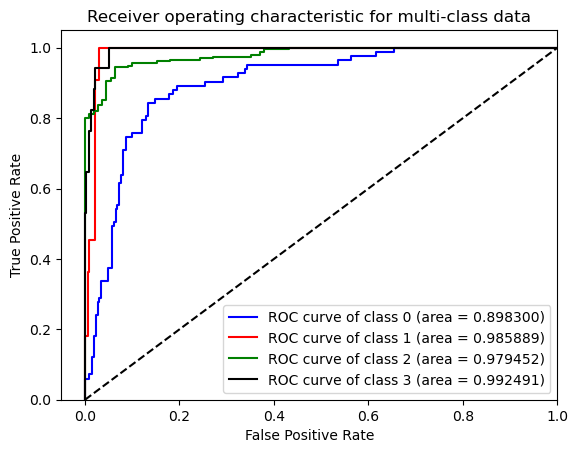

In [104]:
# Binarize the output
y_per = label_binarize(y, classes=['acc', 'good', 'unacc', 'vgood'])
n_classes = y_per.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y_per, test_size=.2, random_state=42)

# Apply the best parameters set found from grind search
classifier = OneVsRestClassifier(SVC(C=1000, gamma=0.001, kernel='rbf', probability=True))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green', 'black'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.6f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# Part 2. Treat the data as Categorical 

In [106]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
car_evaluation = fetch_ucirepo(id=19) 
  
# data (as pandas dataframes) 
X_c = car_evaluation.data.features 
y_c = car_evaluation.data.targets 
  
# metadata 
print(car_evaluation.metadata) 
  
# variable information 
print(car_evaluation.variables) 

{'uci_id': 19, 'name': 'Car Evaluation', 'repository_url': 'https://archive.ics.uci.edu/dataset/19/car+evaluation', 'data_url': 'https://archive.ics.uci.edu/static/public/19/data.csv', 'abstract': 'Derived from simple hierarchical decision model, this database may be useful for testing constructive induction and structure discovery methods.', 'area': 'Other', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1728, 'num_features': 6, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1988, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5JP48', 'creators': ['Marko Bohanec'], 'intro_paper': {'title': 'Knowledge acquisition and explanation for multi-attribute decision making', 'authors': 'M. Bohanec, V. Rajkovič', 'published_in': '8th Intl Workshop on Expert Systems and their Applications, Avignon, France', 'yea

In [112]:
X_c = pd.get_dummies(X_c, columns=["buying", "maint", "doors", "persons", "lug_boot", "safety"]
               , prefix=["buying", "maint", "doors", "persons", "lug_boot", "safety"])

In [109]:
from nested_cv import NestedCV
from sklearn.svm import SVC
from sklearn import neighbors
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score



# When using Random Search, we get a user warning with this little number of hyperparameters
# Suppress it
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

#### 1. K-nearest neighbors

In [114]:
# Number of random trials
NUM_TRIALS = 10

# Define a parameters grid
knn_grid = {"n_neighbors": list(range(1, 40))}

knn = neighbors.KNeighborsClassifier(algorithm='auto')

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=knn, param_grid=knn_grid, cv=inner_cv)
    clf.fit(X_c, y)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X_c, y=y, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

print("mean score of outer cv is {0:6f}"
      .format(nested_score.mean()))

print("standard deviation of outer cv is {0:6f}"
      .format(nested_score.std()))


mean score of outer cv is 0.918996
standard deviation of outer cv is 0.012450


#### 2. Decision Tree

In [116]:
# Number of random trials
NUM_TRIALS = 10

# Define a parameters grid
dt_grid = {'criterion':['gini','entropy'],
           'max_depth':[3,5,7,9,11,15,20,30,40,50,70,90]}

dt = DecisionTreeClassifier(random_state=42)

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=dt, param_grid=dt_grid, cv=inner_cv)
    clf.fit(X_c, y)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X_c, y=y, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

print("mean score of outer cv is {0:6f}"
      .format(nested_score.mean()))

print("standard deviation of outer cv is {0:6f}"
      .format(nested_score.std()))

mean score of outer cv is 0.975121
standard deviation of outer cv is 0.009238


#### 3. Logistic Regression

In [117]:
# Number of random trials
NUM_TRIALS = 10

# Define a parameters grid
lr_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 
          'solver': ['newton-cg', 'lbfgs', 'liblinear']}

lr = LogisticRegression(random_state=42)

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=lr, param_grid=lr_grid, cv=inner_cv)
    clf.fit(X_c, y)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X_c, y=y, cv=outer_cv)
    nested_scores[i] = nested_score.mean()


print("mean score of outer cv is {0:6f}"
      .format(nested_score.mean()))

print("standard deviation of outer cv is {0:6f}"
      .format(nested_score.std()))

mean score of outer cv is 0.931133
standard deviation of outer cv is 0.015341


#### 4. Support Vector Machine

In [118]:
# Number of random trials
NUM_TRIALS = 10

# Define a parameters grid
svm_grid = {'C':[0.1,1,10,100],
          'gamma':[1,0.1,0.01,0.001,0.0001]}

svm = SVC(kernel="rbf", random_state=42)

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svm, param_grid=svm_grid, cv=inner_cv)
    clf.fit(X_c, y)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X_c, y=y, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

# score_difference = non_nested_scores - nested_scores


print("mean score of outer cv is {0:6f}"
      .format(nested_score.mean()))

print("standard deviation of outer cv is {0:6f}"
      .format(nested_score.std()))

mean score of outer cv is 0.998263
standard deviation of outer cv is 0.002318


In [100]:
# Number of random trials
NUM_TRIALS = 10

# Define a parameters grid
svm_grid = {'C':[0.1,1,10,100],
          'gamma':[1,0.1,0.01,0.001,0.0001]}

svm = SVC(kernel="rbf", random_state=42)

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svm, param_grid=svm_grid, cv=inner_cv)
    clf.fit(X, y)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X, y=y, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

# score_difference = non_nested_scores - nested_scores


print("mean score of outer cv is {0:6f}"
      .format(nested_score.mean()))

print("standard deviation of outer cv is {0:6f}"
      .format(nested_score.std()))

mean score of outer cv is 0.994216
standard deviation of outer cv is 0.003653


In [119]:
# Split the dataset in two equal parts
x_train, x_test, y_train, y_test = train_test_split(X_c, y, test_size=0.2, random_state=42)

# Set the parameters by cross-validation
tuned_parameters = [{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                     'gamma': [1e-3, 1e-4],
                     'kernel': ['rbf', 'linear']}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf4 = GridSearchCV(SVC(probability=True), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf4.fit(x_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf4.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf4.cv_results_['mean_test_score']
    stds = clf4.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf4.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf4.predict(x_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 100, 'gamma': 0.001, 'kernel': 'linear'}

Grid scores on development set:

0.176 (+/-0.001) for {'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}
0.176 (+/-0.001) for {'C': 0.001, 'gamma': 0.001, 'kernel': 'linear'}
0.176 (+/-0.001) for {'C': 0.001, 'gamma': 0.0001, 'kernel': 'rbf'}
0.176 (+/-0.001) for {'C': 0.001, 'gamma': 0.0001, 'kernel': 'linear'}
0.176 (+/-0.001) for {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}
0.177 (+/-0.001) for {'C': 0.01, 'gamma': 0.001, 'kernel': 'linear'}
0.176 (+/-0.001) for {'C': 0.01, 'gamma': 0.0001, 'kernel': 'rbf'}
0.177 (+/-0.001) for {'C': 0.01, 'gamma': 0.0001, 'kernel': 'linear'}
0.176 (+/-0.001) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.830 (+/-0.103) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}
0.176 (+/-0.001) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.830 (+/-0.103) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}
0.176 (+/-0.001

##### Plot ROC curve and Calculate AUC score 

And then we want to know the per-class performance of the model

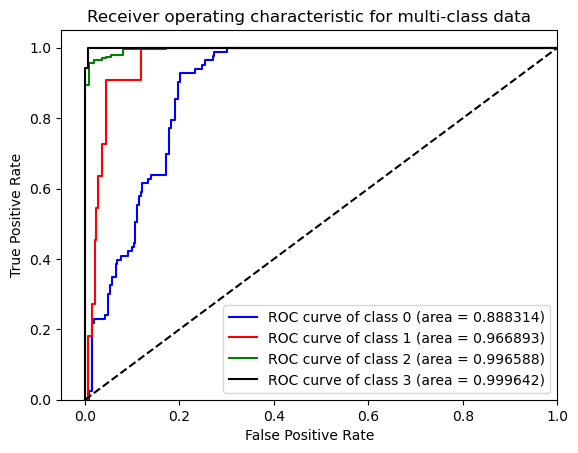

In [120]:
# Binarize the output
y_per = label_binarize(y, classes=['acc', 'good', 'unacc', 'vgood'])
n_classes = y_per.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X_c, y_per, test_size=.2, random_state=42)

# Apply the best parameters set found from grind search
classifier = OneVsRestClassifier(SVC(C=1000, gamma=0.001, kernel='rbf', probability=True))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green', 'black'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.6f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()